# GluonTS API Tutorial: Time Series Forecasting

**Welcome!** This notebook teaches you how to use GluonTS for time series forecasting.

## What You'll Learn

- How to configure and train three different GluonTS models
- When to use each model for your forecasting problem
- Key parameters and their effects on predictions
- How to generate probabilistic forecasts with uncertainty

## The Three Models

We'll explore three forecasting models using the COVID-19 data from the U.S:

1. **DeepAR** - For complex temporal patterns (multiple waves, seasonality)
2. **SimpleFeedForward** - Fast baseline for stable trends
3. **DeepNPTS** - Flexible for changing distributions

## Why COVID-19 Data?

COVID-19 case data is perfect for learning time series forecasting because it has:
- Multiple waves (complex patterns)
- Weekly seasonality (lower reporting on weekends)
- External factors (mobility, policy changes)
- Real-world impact (can affect resource planning and distribution)

## Setup

First, let's import everything we need and load the COVID-19 data.

### Import Required Modules

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# GluonTS models
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.torch.model.deep_npts import DeepNPTSEstimator
from gluonts.evaluation import make_evaluation_predictions

# Our custom utilities
from utils_notebook_loader import quick_load_minimal
from utils_evaluation import calculate_metrics, plot_forecast

print(" All imports successful")

### Load COVID-19 Data

We'll use our quick loader to get US COVID-19 data ready for GluonTS. This gives us:
- Daily COVID-19 cases (our target to forecast)
- Deaths data (helps predict case trends)
- Google mobility data (captures behavioral changes)

Note that the data is already preprocessed and split into training/testing sets.

In [2]:
# Loading data - this performs the following: load, preprocess, split, format for GluonTS
data = quick_load_minimal()

# Extract the data that we need
train_ds = data['train_ds']
test_ds = data['test_ds']
train_df = data['train_df']
test_df = data['test_df']
num_features = len(data['features'])

print(f"\n Data Summary:")
print(f" Training period: {data['info']['train_days']} days")
print(f" Testing period: {data['info']['test_days']} days")
print(f" Target: {data['target']}")
print(f" Features: {num_features} ({', '.join(data['features'])})")


DATA FILES MISSING - ATTEMPTING DOWNLOAD

Missing files: cases.csv, deaths.csv, mobility.csv
Attempting to download from Google Drive...


Missing files: cases.csv, deaths.csv, mobility.csv

Attempting to download from Google Drive...

Successfully downloaded: cases.csv, deaths.csv, mobility.csv

DATA DOWNLOAD SUCCESSFUL

COVID-19 DATA LOADER

Loading raw data...
Loading cases data from data/cases.csv
Loaded 3342 rows, 1154 columns
Loading deaths data from data/deaths.csv
Loaded 3342 rows, 1155 columns
Loading mobility data from data/mobility.csv
Loaded 1847210 rows, 9 columns
  Date range: 2020-02-15 00:00:00 to 2022-02-01 00:00:00
Data files loaded (cases, deaths, mobility)

Preprocessing...

Merging data sources...
Merged data: 1143 days
Date range: 2020-01-22 to 2023-03-09

Feature selection: minimal
Selected 3 features:
  1. Daily_Deaths_MA7
  2. Cumulative_Deaths
  3. CFR

Splitting data (test size: 14 days)...

Train/Test Split:
  Train: 1123 days (2020-01-28 to 2023-02-23)
  T

### Visualize the Data

Let's see what we're working with. This data contains the full COVID-19 case history for the US between 2020 and 2023.

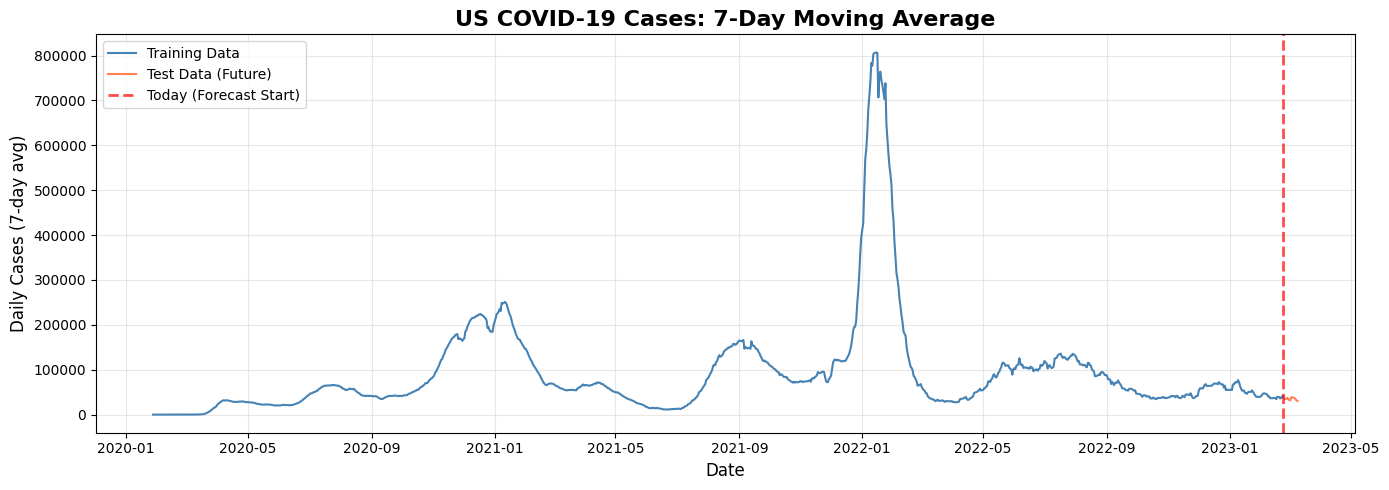


 Note that there are multiple peaks and troughs in the case data.

 This makes sense as there were multiple rounds of vaccinations and Covid variants.


In [3]:
plt.figure(figsize=(14, 5))

# Plot training data
plt.plot(train_df['Date'], train_df[data['target']], 
 label='Training Data', color='steelblue', linewidth=1.5)

# Plot test data
plt.plot(test_df['Date'], test_df[data['target']], 
 label='Test Data (Future)', color='coral', linewidth=1.5)

plt.axvline(x=train_df['Date'].iloc[-1], color='red', 
 linestyle='--', linewidth=2, alpha=0.7, label='Today (Forecast Start)')

plt.title('US COVID-19 Cases: 7-Day Moving Average', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Cases (7-day avg)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Note that there are multiple peaks and troughs in the case data.") 
print("\n This makes sense as there were multiple rounds of vaccinations and Covid variants.")

---

# Part 1: DeepAR

DeepAR is a powerful model that uses **recurrent neural networks (RNNs)** to learn temporal dependencies. Think of it as a model that "remembers" what happened before to make better predictions.

## When should we use DeepAR?

 Use DeepAR when you have:
- **Complex patterns** (like COVID waves)
- **Seasonality** (weekly/monthly cycles)
- **Long-term dependencies** (patterns that repeat over time)
- **Multiple related time series** (we'll only be using one here)

## Key Parameters

Let's understand the important configuration options:

| Parameter | What It Does | Typical Values |
|-----------|-------------|----------------|
| `prediction_length` | How many days to forecast | 7, 14, 30 |
| `context_length` | How much history to use | 2-4x prediction_length |
| `num_layers` | RNN depth (more = complex patterns) | 2-3 |
| `hidden_size` | Network capacity | 40-100 |
| `dropout_rate` | Prevents overfitting | 0.1-0.2 |
| `epochs` | Training iterations | 20-50 |
| `num_feat_dynamic_real` | Number of external features | 0-10+ |

## Configure DeepAR

In [4]:
# Let's configure DeepAR for COVID forecasting
deepar_estimator = DeepAREstimator(
 freq='D', # Daily data
 prediction_length=14, # Forecast 2 weeks ahead
 context_length=60, # Use 2 months of history (4x prediction length)
 num_feat_dynamic_real=num_features, # Include our external features (deaths, mobility)
 
 # Network architecture
 num_layers=2, # Two RNN layers for learning patterns
 hidden_size=40, # Network size (bigger = more complex patterns)
 dropout_rate=0.1, # Regularization to prevent overfitting
 
 # Training settings
 lr=0.001, # our learning rate
 batch_size=32,
 num_batches_per_epoch=50,
 trainer_kwargs={"max_epochs": 10}
)

print(" DeepAR congurations:")
print(f" • Forecasting: 14 days ahead")
print(f" • Using: 60 days of history")
print(f" • Features: {num_features} (deaths + mobility)")
print(f" • Network: 2 layers, size 40")
print(f" • Training: 10 epochs (for a faster training)")

 DeepAR congurations:
 • Forecasting: 14 days ahead
 • Using: 60 days of history
 • Features: 3 (deaths + mobility)
 • Network: 2 layers, size 40
 • Training: 10 epochs (for a faster training)


## Train DeepAR

Now let's train the model on our COVID data. This will take a minute or two.

In [5]:
print(" Training DeepAR on COVID-19 data...")
print(" Note that this uses PyTorch Lightning under the hood\n")

# Train the model
deepar_predictor = deepar_estimator.train(train_ds)

print("\n Finished training DeepAR!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


 Training DeepAR on COVID-19 data...
 Note that this uses PyTorch Lightning under the hood



Missing logger folder: /workspace/lightning_logs

  | Name  | Type        | Params | In sizes                                                         | Out sizes   
------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 26.4 K | [[1, 1], [1, 1], [1, 1152, 7], [1, 1152], [1, 1152], [1, 14, 7]] | [1, 100, 14]
------------------------------------------------------------------------------------------------------------------------
26.4 K    Trainable params
0         Non-trainable params
26.4 K    Total params
0.105     Total estimated model params size (MB)


Training: |                                                                                       | 0/? [00:00…

Epoch 0, global step 50: 'train_loss' reached 11.54909 (best 11.54909), saving model to '/workspace/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 11.15942 (best 11.15942), saving model to '/workspace/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 11.14729 (best 11.14729), saving model to '/workspace/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 11.09884 (best 11.09884), saving model to '/workspace/lightning_logs/version_0/checkpoints/epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' was not in top 1
Epoch 8, global step 450: 'train_loss' was not in top 1
Epoch 9, global step 500: 'train_loss' was


 Finished training DeepAR!


## Generate Forecasts

DeepAR produces **probabilistic forecasts** - not just a single prediction, but a distribution of possible futures. This gives us confidence intervals!

In [6]:
print(" Generating probabilistic forecasts...")

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
 dataset=test_ds,
 predictor=deepar_predictor,
 num_samples=100 # we'll generate 100 possible futures for uncertainty
)

forecasts = list(forecast_it)
ground_truths = list(ts_it)

# Get the first (and only) forecast
deepar_forecast = forecasts[0]
actual = ground_truths[0]

print(" Forecasts Summary:")
print(f" • Mean prediction: {deepar_forecast.mean.mean():.0f} cases/day")
print(f" • Forecast range: {deepar_forecast.mean.min():.0f} to {deepar_forecast.mean.max():.0f}")
print(f" • Uncertainty (90% CI): {deepar_forecast.quantile(0.05).mean():.0f} - {deepar_forecast.quantile(0.95).mean():.0f}")

 Generating probabilistic forecasts...
 Forecasts Summary:
 • Mean prediction: 47070 cases/day
 • Forecast range: 38769 to 51976
 • Uncertainty (90% CI): 8111 - 85944


## Visualize DeepAR Predictions

Let's see how well DeepAR captured the COVID patterns!

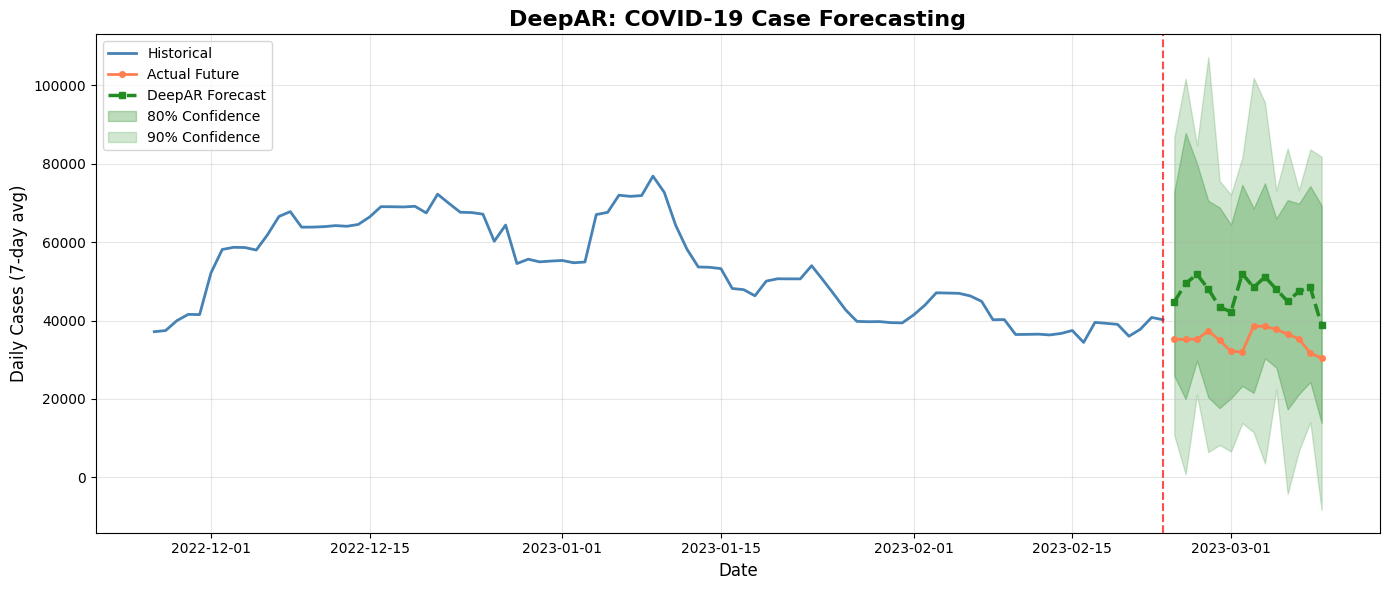


 Observe that DeepAR captures the trend and provides uncertainty bounds.


In [7]:
plt.figure(figsize=(14, 6))

# Historical data
train_dates = train_df['Date'].values[-90:] # Last 3 months for context
train_values = train_df[data['target']].values[-90:]
plt.plot(train_dates, train_values, label='Historical', color='steelblue', linewidth=2)

# Forecast dates
last_train_date = pd.Timestamp(train_dates[-1])
forecast_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=14, freq='D')
actual_values = actual[-14:]

# Actual future
plt.plot(forecast_dates, actual_values, label='Actual Future', 
 color='coral', linewidth=2, marker='o', markersize=4)

# DeepAR prediction
plt.plot(forecast_dates, deepar_forecast.mean, label='DeepAR Forecast', 
 color='forestgreen', linewidth=2.5, marker='s', markersize=5, linestyle='--')

# Confidence intervals
plt.fill_between(forecast_dates, deepar_forecast.quantile(0.1), deepar_forecast.quantile(0.9),
 alpha=0.3, color='forestgreen', label='80% Confidence')
plt.fill_between(forecast_dates, deepar_forecast.quantile(0.05), deepar_forecast.quantile(0.95),
 alpha=0.2, color='forestgreen', label='90% Confidence')

plt.axvline(x=last_train_date, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.title('DeepAR: COVID-19 Case Forecasting', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Cases (7-day avg)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Observe that DeepAR captures the trend and provides uncertainty bounds.")

## Evaluate DeepAR Performance

In [8]:
# Calculate metrics
deepar_metrics = calculate_metrics(deepar_forecast.mean, actual_values)

print("\n DeepAR Performance Metrics:")
print("=" * 50)
print(f" MAE (Mean Absolute Error): {deepar_metrics['mae']:,.2f}")
print(f" RMSE (Root Mean Squared Error): {deepar_metrics['rmse']:,.2f}")
print(f" MAPE (Mean Absolute % Error): {deepar_metrics['mape']:.2f}%")
print("=" * 50)

# Evaluate the performance of DeepAR
if deepar_metrics['mape'] < 15:
 print("\n Excellent! DeepAR is handling the COVID patterns pretty well.")
elif deepar_metrics['mape'] < 25:
 print("\n Good performance! DeepAR captured the main trends.")
else:
 print("\n Decent baseline! May need to consider tuning parameters for better results.")


 DeepAR Performance Metrics:
 MAE (Mean Absolute Error): 11,991.29
 RMSE (Root Mean Squared Error): 12,487.31
 MAPE (Mean Absolute % Error): 34.57%

 Decent baseline! May need to consider tuning parameters for better results.


---

# Part 2: SimpleFeedForward - The Fast Baseline

SimpleFeedForward - a simple neural network without fancy recurrent connections.

## When should we use SimpleFeedForward?

 Use SimpleFeedForward when you need:
- **Fast training** (roughly 10x faster than DeepAR)
- **Quick experiments** (test various scenarios rapidly)
- **Stable trends** (works well when patterns don't shift much)
- **A baseline** (good baseline for future comparisons)

## Key Differences from DeepAR

| Aspect | DeepAR | SimpleFeedForward |
|--------|--------|-------------------|
| Architecture | RNN (remembers past) | Feedforward (no memory) |
| Training Speed | Slower (1-5 min) | Fast (10-30 sec) |
| Best For | Complex patterns | Stable trends |
| Parameters | More to tune | Fewer, simpler |

## Configure SimpleFeedForward

In [9]:
# SimpleFeedForward configuration
feedforward_estimator = SimpleFeedForwardEstimator(
 prediction_length=14,
 context_length=60,
 
 # Network architecture (its simpler than DeepAR)
 hidden_dimensions=[40, 40], # Two hidden layers
 
 # Training settings (we'll use more epochs since it's fast)
 lr=0.001,
 batch_size=32,
 num_batches_per_epoch=50,
 trainer_kwargs={"max_epochs": 20}
)

print(" SimpleFeedForward congurations:")
print(f" • Prediction length: 14 days")
print(f" • Context length: 60 days")
print(f" • Hidden layers: {feedforward_estimator.hidden_dimensions}")
print(f" • Learning rate: {feedforward_estimator.lr}")
print(f" • Training epochs: 20")

print("\nNote: SimpleFeedForward is a simple baseline model.")
print("\nIt doesn't use freq or external features like DeepAR does.")

 SimpleFeedForward congurations:
 • Prediction length: 14 days
 • Context length: 60 days
 • Hidden layers: [40, 40]
 • Learning rate: 0.001
 • Training epochs: 20

Note: SimpleFeedForward is a simple baseline model.

It doesn't use freq or external features like DeepAR does.


## Train SimpleFeedForward

Watch how fast this trains compared to DeepAR!

In [10]:
import time

print(" Training SimpleFeedForward (this should be quick!)...\n")

start_time = time.time()
feedforward_predictor = feedforward_estimator.train(train_ds)
training_time = time.time() - start_time

print(f"\n Training complete in {training_time:.1f} seconds!")
print(f" (Told you it was fast! )")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | SimpleFeedForwardModel | 25.5 K
-------------------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)


 Training SimpleFeedForward (this should be quick!)...



Training: |                                                                                                   …

Epoch 0, global step 50: 'train_loss' reached 12.29462 (best 12.29462), saving model to '/workspace/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 11.16460 (best 11.16460), saving model to '/workspace/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 10.86977 (best 10.86977), saving model to '/workspace/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 10.76893 (best 10.76893), saving model to '/workspace/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 10.74196 (best 10.74196), saving model to '/workspace/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 10.72795 (best 10.72795), saving model to '/workspace/lightning_logs/version_1/checkpoints/epoch=5-step=3


 Training complete in 5.7 seconds!
 (Told you it was fast! )


## Generate SimpleFeedForward Forecasts

In [11]:
print(" Generating SimpleFeedForward forecasts...")

forecast_it, ts_it = make_evaluation_predictions(
 dataset=test_ds,
 predictor=feedforward_predictor,
 num_samples=100
)

forecasts = list(forecast_it)
ff_forecast = forecasts[0]

print(" Forecasts generated!")
print(f"\n Forecast Summary:")
print(f" Mean prediction: {ff_forecast.mean.mean():.0f} cases/day")
print(f" Forecast range: {ff_forecast.mean.min():.0f} to {ff_forecast.mean.max():.0f}")

 Generating SimpleFeedForward forecasts...
 Forecasts generated!

 Forecast Summary:
 Mean prediction: 40499 cases/day
 Forecast range: 37182 to 42722


## Visualize SimpleFeedForward Predictions

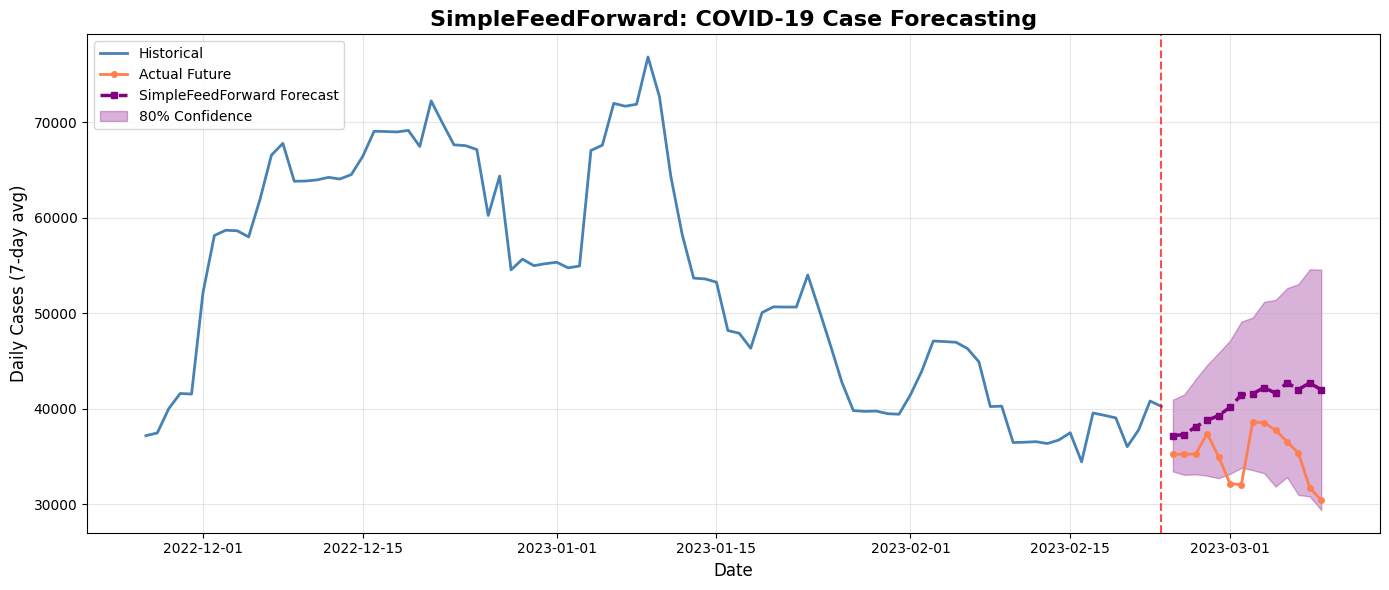


 SimpleFeedForward gives a smooth baseline forecast!


In [12]:
plt.figure(figsize=(14, 6))

# Historical
plt.plot(train_dates, train_values, label='Historical', color='steelblue', linewidth=2)

# Actual
plt.plot(forecast_dates, actual_values, label='Actual Future', 
 color='coral', linewidth=2, marker='o', markersize=4)

# SimpleFeedForward prediction
plt.plot(forecast_dates, ff_forecast.mean, label='SimpleFeedForward Forecast', 
 color='purple', linewidth=2.5, marker='s', markersize=5, linestyle='--')

# Confidence intervals
plt.fill_between(forecast_dates, ff_forecast.quantile(0.1), ff_forecast.quantile(0.9),
 alpha=0.3, color='purple', label='80% Confidence')

plt.axvline(x=last_train_date, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.title('SimpleFeedForward: COVID-19 Case Forecasting', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Cases (7-day avg)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n SimpleFeedForward gives a smooth baseline forecast!")

## Evaluate SimpleFeedForward Performance

In [13]:
ff_metrics = calculate_metrics(ff_forecast.mean, actual_values)

print("\n SimpleFeedForward Performance Metrics:")
print("=" * 50)
print(f" MAE: {ff_metrics['mae']:,.2f}")
print(f" RMSE: {ff_metrics['rmse']:,.2f}")
print(f" MAPE: {ff_metrics['mape']:.2f}%")
print("=" * 50)
print(f" Training time: {training_time:.1f} seconds")
print("=" * 50)


 SimpleFeedForward Performance Metrics:
 MAE: 5,420.22
 RMSE: 6,345.10
 MAPE: 16.12%
 Training time: 5.7 seconds


---

# Part 3: DeepNPTS - The Flexible One

DeepNPTS (Deep Non-Parametric Time Series) is special - it doesn't assume your data follows any specific distribution (like normal or Poisson). Instead, it learns the distribution directly from your data.

## When to Use DeepNPTS

 Use DeepNPTS when you have:
- **Shifting distributions** (like COVID waves changing patterns)
- **Unusual data** (not normal distribution)
- **Regime changes** (data behavior changes over time)
- **Heavy tails** (rare extreme events)

## Why It's Different

Most models assume your data follows a specific mathematical distribution. DeepNPTS says: "I'll learn the distribution from the data itself!" This makes it flexible for COVID data where each wave behaves differently.

## Configure DeepNPTS

In [14]:
# DeepNPTS configuration
deepnpts_estimator = DeepNPTSEstimator(
 freq='D',
 prediction_length=14,
 context_length=60,
 num_feat_dynamic_real=num_features,
 
 # Network architecture
 num_hidden_nodes=[40], # Single hidden layer
 dropout_rate=0.1,
 
 # Training settings
 lr=0.001,
 epochs=15, # DeepNPTS accepts epochs directly!
 batch_size=32,
 num_batches_per_epoch=50
)

print(" DeepNPTS configured!")
print(f"\nConfiguration:")
print(f" • Frequency: {deepnpts_estimator.freq}")
print(f" • Prediction length: 14 days")
print(f" • Context length: 60 days")
print(f" • Features: {deepnpts_estimator.num_feat_dynamic_real}")
print(f" • Hidden nodes: {deepnpts_estimator.num_hidden_nodes}")
print(f" • Dropout: {deepnpts_estimator.dropout_rate}")
print(f" • Learning rate: {deepnpts_estimator.lr}")
print(f" • Training epochs: {deepnpts_estimator.epochs}")
print("\nNote: DeepNPTS uniquely accepts 'epochs' as a direct parameter!")

 DeepNPTS configured!

Configuration:
 • Frequency: D
 • Prediction length: 14 days
 • Context length: 60 days
 • Features: 3
 • Hidden nodes: [40]
 • Dropout: 0.1
 • Learning rate: 0.001
 • Training epochs: 15

Note: DeepNPTS uniquely accepts 'epochs' as a direct parameter!


## Train DeepNPTS

In [15]:
print(" Training DeepNPTS on COVID-19 data...")
print("(Learning the distribution directly from the data)\n")

deepnpts_predictor = deepnpts_estimator.train(train_ds)

print("\n Training complete!")

 Training DeepNPTS on COVID-19 data...
(Learning the distribution directly from the data)

Loss for epoch 0: 10971.17017578125
Loss for epoch 1: 7920.4574365234375
Loss for epoch 2: 6437.021821289062
Loss for epoch 3: 4919.765126953125
Loss for epoch 4: 4489.249775390625
Loss for epoch 5: 3413.055285644531
Loss for epoch 6: 3384.3100927734376
Loss for epoch 7: 2729.1803735351564
Loss for epoch 8: 2675.142137451172
Loss for epoch 9: 2498.556545410156
Loss for epoch 10: 2053.2359924316406
Loss for epoch 11: 1985.2569873046875
Loss for epoch 12: 2358.1847680664064
Loss for epoch 13: 2198.0456213378907
Loss for epoch 14: 1947.6705432128906
Best loss: 1947.6705432128906

 Training complete!


## Generate DeepNPTS Forecasts

In [16]:
print(" Generating DeepNPTS forecasts...")

forecast_it, ts_it = make_evaluation_predictions(
 dataset=test_ds,
 predictor=deepnpts_predictor,
 num_samples=100
)

forecasts = list(forecast_it)
npts_forecast = forecasts[0]

print(" Forecasts generated!")
print(f"\n Forecast Summary:")
print(f" Mean prediction: {npts_forecast.mean.mean():.0f} cases/day")
print(f" Forecast range: {npts_forecast.mean.min():.0f} to {npts_forecast.mean.max():.0f}")

 Generating DeepNPTS forecasts...
 Forecasts generated!

 Forecast Summary:
 Mean prediction: 40106 cases/day
 Forecast range: 40004 to 40164


## Visualize DeepNPTS Predictions

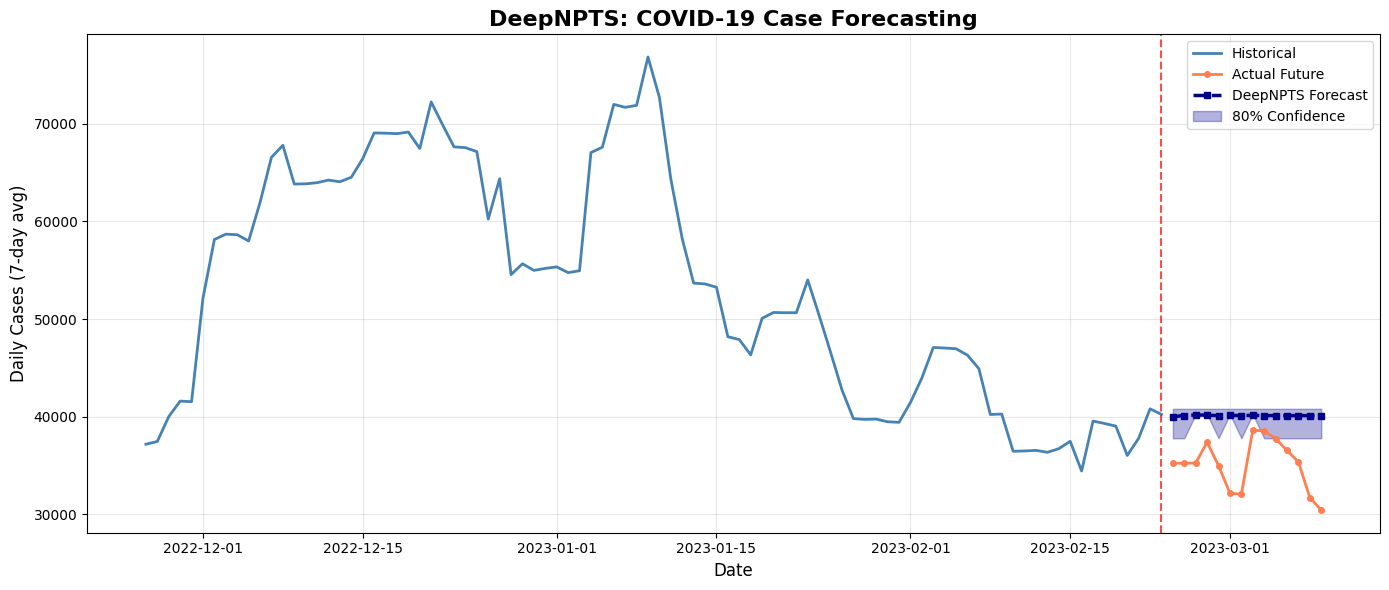


 DeepNPTS adapts to the data's natural distribution!


In [17]:
plt.figure(figsize=(14, 6))

# Historical
plt.plot(train_dates, train_values, label='Historical', color='steelblue', linewidth=2)

# Actual
plt.plot(forecast_dates, actual_values, label='Actual Future', 
 color='coral', linewidth=2, marker='o', markersize=4)

# DeepNPTS prediction
plt.plot(forecast_dates, npts_forecast.mean, label='DeepNPTS Forecast', 
 color='darkblue', linewidth=2.5, marker='s', markersize=5, linestyle='--')

# Confidence intervals
plt.fill_between(forecast_dates, npts_forecast.quantile(0.1), npts_forecast.quantile(0.9),
 alpha=0.3, color='darkblue', label='80% Confidence')

plt.axvline(x=last_train_date, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.title('DeepNPTS: COVID-19 Case Forecasting', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Cases (7-day avg)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n DeepNPTS adapts to the data's natural distribution!")

## Evaluate DeepNPTS Performance

In [18]:
npts_metrics = calculate_metrics(npts_forecast.mean, actual_values)

print("\n DeepNPTS Performance Metrics:")
print("=" * 50)
print(f" MAE: {npts_metrics['mae']:,.2f}")
print(f" RMSE: {npts_metrics['rmse']:,.2f}")
print(f" MAPE: {npts_metrics['mape']:.2f}%")
print("=" * 50)


 DeepNPTS Performance Metrics:
 MAE: 5,027.73
 RMSE: 5,629.67
 MAPE: 14.95%


---

# Quick Comparison: Which Model Should You Choose?

Let's compare all three models side by side!

In [19]:
# Create comparison table
comparison = pd.DataFrame([
 {'Model': 'DeepAR', 'MAPE (%)': deepar_metrics['mape'], 
 'MAE': deepar_metrics['mae'], 'RMSE': deepar_metrics['rmse']},
 {'Model': 'SimpleFeedForward', 'MAPE (%)': ff_metrics['mape'], 
 'MAE': ff_metrics['mae'], 'RMSE': ff_metrics['rmse']},
 {'Model': 'DeepNPTS', 'MAPE (%)': npts_metrics['mape'], 
 'MAE': npts_metrics['mae'], 'RMSE': npts_metrics['rmse']}
])

comparison = comparison.sort_values('MAPE (%)')
comparison.insert(0, 'Rank', [1, 2, 3])

print("\n" + "=" * 70)
print(" MODEL COMPARISON")
print("=" * 70)
print(comparison.to_string(index=False))
print("=" * 70)

winner = comparison.iloc[0]['Model']
print(f"\n Winner: {winner}!")
print("\nNote: These results are from a quick training demo.")
print("For production, train with more epochs and tune hyperparameters!")


 MODEL COMPARISON
 Rank             Model  MAPE (%)          MAE         RMSE
    1          DeepNPTS 14.950000  5027.730957  5629.668945
    2 SimpleFeedForward 16.122177  5420.215332  6345.104492
    3            DeepAR 34.569341 11991.291992 12487.311523

 Winner: DeepNPTS!

Note: These results are from a quick training demo.
For production, train with more epochs and tune hyperparameters!


---

# Summary: Decision Guide

Now you know how to use all three GluonTS models! Here's a quick guide for choosing:

## Choose DeepAR When:
- You have **complex temporal patterns** (multiple waves, cycles)
- You need to capture **long-term dependencies**
- You have **seasonality** (daily, weekly, monthly patterns)
- Accuracy is more important than speed

## Choose SimpleFeedForward When:
- You need **fast training** for experimentation
- Your data has **stable, smooth trends**
- You want a **baseline** to compare against
- You need quick retraining in production

## Choose DeepNPTS When:
- Your data has **shifting distributions**
- You see **regime changes** (behavior changes over time)
- You have **unusual distributions** (not normal)
- You want flexibility without distribution assumptions

---

## Next Steps

Want to see a complete COVID-19 forecasting application? Check out:
- **`GluonTS.example.ipynb`** - Full pipeline with model comparison, uncertainty quantification, and scenario analysis

Want to learn more about the parameters?
- **`GluonTS.API.md`** - Detailed API documentation

---